In [1]:
import pandas as pd 
import numpy as np

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import random
import base64
import requests
import json

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Pre-processing of **Tags** dataset

💡 Retrieve audio features from Spotify API to get audio features of the tracks in `tags` dataset.

First, we make basic cleaning on the dataset.

In [2]:
tags = pd.read_csv('data/tags.csv')

#Keep only the columns we need
columns_to_keep = ['track', 'artist', 'seeds', 'arousal_tags', 'dominance_tags', 'spotify_id', 'genre']
tags = tags[columns_to_keep]

#Rename columns 
tags = tags.rename(columns={'valence_tags': 'valence', 
                            'arousal_tags': 'arousal', 
                            'dominance_tags': 'dominance',
                            'seeds' : 'tags', 
                            'spotify_id' : 'track_id'})

tags['tags'] = tags['tags'].apply(lambda x: x[2:-2].replace("'", "").split(', '))

tags

,track,artist,tags,arousal,dominance,track_id,genre
0,'Till I Collapse,Eminem,[aggressive],5.273125,5.690625,4xkOaSrkexMciUUogZKVTS,rap
1,St. Anger,Metallica,[aggressive],5.833000,5.427250,3fOc9x06lKJBhz435mInlH,metal
2,Speedin',Rick Ross,[aggressive],5.870000,5.490000,3Y96xd4Ce0J47dcalLrEC8,rap
3,Bamboo Banga,M.I.A.,"[aggressive, fun, sexy, energetic]",5.537214,5.691357,6tqFC1DIOphJkCwrjVzPmg,hip-hop
4,Die MF Die,Dope,[aggressive],5.348235,5.441765,5bU4KX47KqtDKKaLM4QCzh,metal
...,...,...,...,...,...,...,...
89996,Battle,Gaby Hoffmann & Jay Duplass,[transparent],3.450000,5.330000,NaN,NaN
89997,Hands Tied to the Roots of a Hemorrhage,Omar Rodriguez-Lopez,[transparent],4.132254,5.570563,NaN,progressive rock
89998,Crookfield Zoo,Ace White,[transparent],3.450000,5.330000,NaN,NaN
89999,Transparent (Full Version),Second Chyld,[transparent],3.450000,5.330000,NaN,NaN


We plot a wordcloud to get a quick overview of the tags we have.

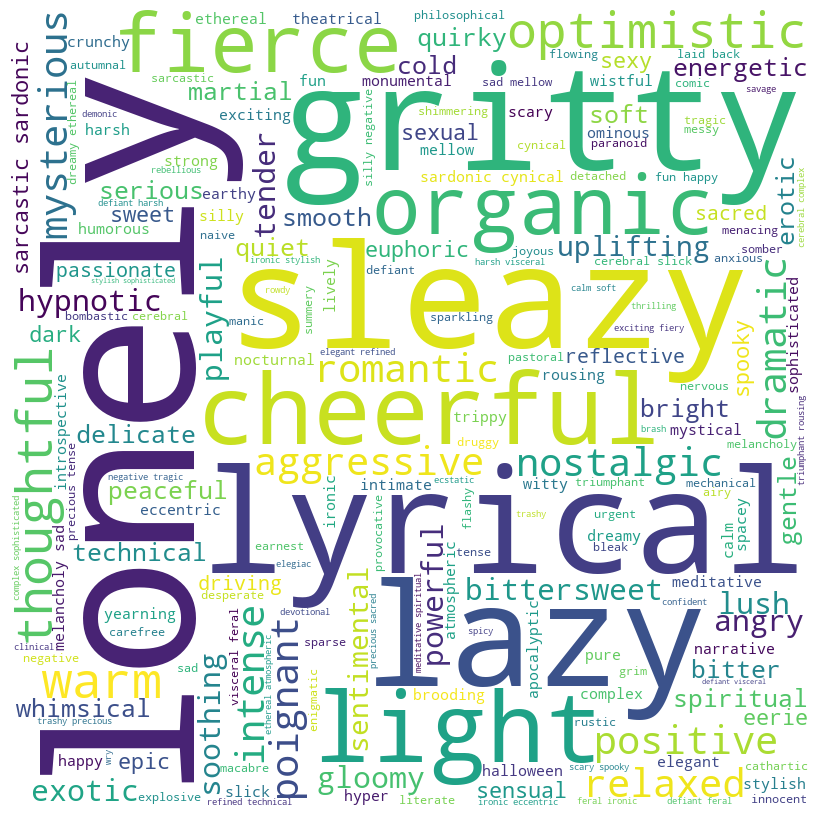

In [3]:
#Retrieve all tags and store them in a list
all_tags = tags['tags'].to_list()
random.shuffle(all_tags)
all_tags = ' '.join([item for sublist in all_tags for item in sublist])

#Create a wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(all_tags)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
  
plt.show()

We count how many tracks have a spotify_id.

In [4]:
with_spotify_ids = tags[~tags['track_id'].isnull()]
print('Number of tracks with spotify id: {nb} ({per:.2f}%)'
      .format(nb = len(with_spotify_ids), per = len(with_spotify_ids)/len(tags)*100))

Number of tracks with spotify id: 61630 (68.48%)


The number of tracks with spotify_id is enough for the purpose of our project. Hence, we keep only these tracks for the following.

### Retrieve features from Spotify API

First, we define some functions to make the get requests to Spotify API. 

In [5]:
def get_tokens() : 
    """
    Get access token for Spotify API
    You need to create a Spotify app (https://developer.spotify.com/dashboard) to get the client_id and client_secret.
    Then create a file named keys.json with the following structure:
    {
        "client_id": "your_client_id",
        "client_secret": "your_client_secret"
    }
    And store it in the same folder as this notebook.

    Returns:
        access_token (str): access token for Spotify API
    """
    with open('keys.json', 'r') as f:
        keys = json.load(f)

    client_id = keys['client_id']
    client_secret = keys['client_secret']
    client_creds = f"{client_id}:{client_secret}"

    # Encode the concatenated string as base64
    client_creds_b64 = base64.b64encode(client_creds.encode())

    # Define the headers for the request to the Spotify Accounts service
    token_url = 'https://accounts.spotify.com/api/token'
    token_data = {
        "grant_type": "client_credentials"
    }
    token_headers = {
        "Authorization": f"Basic {client_creds_b64.decode()}",
    }

    # Make the request to the Spotify Accounts service to get an access token
    response = requests.post(token_url, data=token_data, headers=token_headers)

    # Extract the access token from the response
    access_token = response.json()["access_token"]

    return access_token


def get_audio_features(track_ids, access_token):
    """
    Get audio features from Spotify API for a list of track IDs

    Args:
        track_ids (list): List of Spotify track IDs
        access_token (str): Access token for Spotify API
    
    Returns:
        features_list (list): List of dictionaries containing the audio features for each track
    """
    
    # Spotify API endpoint for getting audio features
    url = 'https://api.spotify.com/v1/audio-features/'

    # header for the request with authorization token
    headers = {
        'Authorization': 'Bearer ' + access_token
    }

    # convert list of track IDs to comma-separated string
    track_ids_str = ','.join(track_ids)

    # parameters for the request to the Spotify API
    params = {
        'ids': track_ids_str
    }

    # make the request to the Spotify API
    response = requests.get(url, headers=headers, params=params)

    # check if the request was successful
    if response.status_code == 200:
        # get the JSON response content
        response_json = json.loads(response.content)

        # extract the audio features for each track
        features_list = []
        for track_features in response_json['audio_features']:
            features = {
                'track_id': track_features['id'],
                'acousticness': track_features['acousticness'],
                'danceability': track_features['danceability'],
                'energy': track_features['energy'],
                'instrumentalness': track_features['instrumentalness'],
                'key': track_features['key'],
                'liveness': track_features['liveness'],
                'loudness': track_features['loudness'],
                'mode': track_features['mode'],
                'speechiness': track_features['speechiness'],
                'tempo': track_features['tempo'],
                'time_signature': track_features['time_signature'],
                'valence': track_features['valence'],
            }
            features_list.append(features)

        return features_list
    else:
        print('Error:', response.status_code)

def retrieve_features_batch(tracks, access_token, id_batch, last=False, batch_size=100):
    """
    Retrieve audio features for a batch of tracks from the Spotify API

    Args:
        tracks (pd.DataFrame): Dataframe containing the tracks
        access_token (str): Access token for Spotify API
        id_batch (int): Batch number
        last (bool): True if it is the last batch
        batch_size (int): Number of tracks per batch
    
    Returns:
        merged_df (pd.DataFrame): Dataframe containing the tracks and their audio features
    """ 
    
    #Keep a subset of rows from the tracks dataframe
    if last:
        tracks_df = tracks.iloc[id_batch*batch_size:]
    else:
        tracks_df = tracks.iloc[id_batch*batch_size:(id_batch+1)*batch_size]
   
    #Get the track IDs
    track_ids = tracks_df['track_id'].to_list()

    #Get the audio features for the tracks
    features_list = get_audio_features(track_ids, access_token)

    #Convert the list of dictionaries to a dataframe
    features_df = pd.DataFrame(features_list)

    #Merge the audio features with the tracks dataframe on track_id
    merged_df = pd.merge(tracks_df, features_df, on='track_id')
            
    return merged_df

def retrieve_features(tracks_df):
    """
    Retrieve audio features for all tracks

    Args:
        tracks_df : Dataframe of all tracks

    Returns:
        tracks_final : Dataframe containing the tracks and their audio features
    """
    #Retrieve access_token 
    access_token = get_tokens()

    #Get the number of batches
    nb_batches = len(tracks_df)//100

    #Initialize empty dataframe
    tracks_final = None

    #Retrieve audio features for each batch
    for i in range(nb_batches):
        print('Batch {i}/{nb}'.format(i=i, nb=nb_batches+1))
        try : 
            tracks_batch = retrieve_features_batch(tracks_df, access_token, i)
        except TypeError:
            print('Error in batch {i}'.format(i=i))
            continue

        if i == 0:
            tracks_final = tracks_batch
        else:
            tracks_final = pd.concat([tracks_final, tracks_batch], ignore_index=True)

    #Retrieve audio features for the last batch
    tracks_batch = retrieve_features_batch(tracks_df, access_token, nb_batches, last=True)
    tracks_final = pd.concat([tracks_final, tracks_batch], ignore_index=True)

    tracks_final.to_csv('tracks.csv', index=False)

    return tracks_final

We retrieve all the audio features from the Spotify API and store the final dataset in `tracks.csv`.

In [ ]:
tracks_final = retrieve_features(with_spotify_ids)

In [ ]:
print(len(with_spotify_ids)-len(tracks_final), 'tracks were not found in Spotify')
tracks_final

40 tracks were not found in Spotify


,track,artist,tags,arousal,dominance,track_id,genre,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,'Till I Collapse,Eminem,[aggressive],5.273125,5.690625,4xkOaSrkexMciUUogZKVTS,rap,0.06220,0.548,0.847,0.000000,1,0.0816,-3.237,1,0.1860,171.447,4,0.1000
1,St. Anger,Metallica,[aggressive],5.833000,5.427250,3fOc9x06lKJBhz435mInlH,metal,0.00131,0.249,0.949,0.022800,2,0.0953,-2.642,0,0.0678,185.252,4,0.4980
2,Speedin',Rick Ross,[aggressive],5.870000,5.490000,3Y96xd4Ce0J47dcalLrEC8,rap,0.10900,0.668,0.787,0.000000,1,0.2100,-4.226,1,0.0429,100.059,4,0.4780
3,Bamboo Banga,M.I.A.,"[aggressive, fun, sexy, energetic]",5.537214,5.691357,6tqFC1DIOphJkCwrjVzPmg,hip-hop,0.04930,0.805,0.918,0.000000,9,0.0691,-4.554,1,0.2120,125.984,4,0.7130
4,Die MF Die,Dope,[aggressive],5.348235,5.441765,5bU4KX47KqtDKKaLM4QCzh,metal,0.00169,0.657,0.960,0.000997,5,0.1090,-3.524,0,0.0700,126.020,4,0.5670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61585,Secret,Quietdrive,[transparent],3.450000,5.330000,2bRIsZ92JRKlvQOZlyR9CO,NaN,0.03340,0.396,0.915,0.000000,0,0.1350,-5.126,0,0.1560,167.996,4,0.0734
61586,The Last of the Rest Was the End,Medications,[transparent],3.450000,5.330000,7o3Np7cho9cBCrNDokxzYC,NaN,0.00433,0.244,0.866,0.072200,2,0.0782,-5.774,0,0.0674,144.844,3,0.3400
61587,Lovechild,Daniel Lanois,[transparent],4.405000,5.625000,4fVObxldDzxxRD6a5Eth9s,indie,0.90100,0.236,0.107,0.748000,10,0.1120,-20.091,0,0.0344,79.476,4,0.0720
61588,Last Inhale,Tapage,[transparent],3.341667,4.466667,5WxwRwUQ4R4L46VEm3213y,ambient,0.07180,0.542,0.909,0.817000,2,0.1250,-8.977,0,0.1230,160.011,4,0.0552
